# To-Do next:
1. ~~Make `scene_path` update using `get_scene_path`~~
2. ~~Update `scene` in `sim_settings` to use the new `scene_path`~~
3. ~~Fix the positioning of agent on the map (done?)~~
4. ~~Create a video showing the agent spinning around to demonstrate environment~~
5. ~~Check to see if there is a better way to account for agent height (?)~~
6. ~~Work out 360 view~~ _(Assuming that this is not required for now)_
7. ~~Work out prompt for agent to describe task~~
8. ~~Hook up a ViT~~
9. ~~Make agent take a series of steps~~
10. ~~Plot trajectory on a map~~
11. ~~Try using GPT4 LLM as decision-maker~~
12. ~~Try injecting a panoramic view into the decision maker to help ground the decision making~~ (limited / no noticeable benefit)
13. ~~Try injecting a panoramic view into the view description~~ (limited / no noticeable benefit)
14. ~~Try injecting the navigation instructions into the view descriptions~~ (some benefit, but is leading to stronger confidence in hallucinations)
15. ~~Make agent able to iterate through multiple trajectories~~
16. ~~Make agent able to iterate through multiple scenes~~
17. Try using GPT4 LLM with full conversation history as decision-maker
18. ~~Try using GPT4 to self-prompt~~
19. Try creating an orthogonal orientator?
20. ~~Provide agent with environment collision data~~
21. Test checking the chosen direction view after selecting an initial action
22. ~~Check error distance per action taken~~
23. ~~Return an output dictionary of reasoning and action taken per step (for posterity?)~~
24. ~~Run different scans~~
25. ~~Run multiple scans~~
26. ~~Plot error distances~~
27. ~~Improve action selection robustness (enforce LLM selection more tightly, try/except, regex)~~
28. ~~Add ability to save outputs~~
29. ~~Add ability to load outputs~~
30. ~~Add ability to work out proportional progress~~
31. Try comparing observations to panorama to generate correct understandings
32. Try using a more sophisticated model (e.g. `o1`)
33. Implement a stronger `past_action_story` to better help navigate progress
34. Implement a better `Navigation Checkpoints` to help ground the model in understanding where it is
35. Read up on current implementations on zero/few-shot VLN to get some ideas
36. ~~Reject training trajectories that cannot be achieved within 50 steps~~
37. ~~Implement more granular rotation / views (45 degrees?)~~
38. Implement training LLM prompts
39. ~~Structure training loop / functions~~
40. ~~Structure training data~~
41. Finetune

# Major milestones
1. ~~Map agent in environment~~
2. ~~Agent random-walk with position trace~~
3. Work out 360 view
4. ~~Hook up vision transformer~~
5. ~~Hook up LLM~~
7. Hook up second vision transformer
8. ??
9. Write-up

# Basic Schematic

![Basic Schematic of Modelling Approach](basic_schematic.drawio.png)

#### Notes:
 - "Hop over the coffee table" (scan_id: S9hNv5qa7GM, instruction_id: 167)
 - Uses outdoor spiral staircase (scan_id: PX4nDJXEHrG, instruction_id: 2460)

# 1. Introduction

# 2. Setup
This section is used to set up the workbook by:
1. Importing required modules
2. Establishing Folder Paths and Directories
3. Defining required functions

## 2.1 Setup: Required module imports

In [1]:
# Required imports
import os
import json
import numpy as np
import pandas as pd
import random
import magnum as mn
from PIL import Image
from matplotlib import pyplot as plt
import textwrap
import math
import cv2
import copy
import re
from datetime import datetime
import pickle
import gc
import magnum as mn
from quaternion import from_rotation_vector

# Habitat-sim related imports
import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps

# VLM and LLM related imports
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from openai import OpenAI

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


## 2.2 Setup: Directory paths and filenames

In [2]:
# Core home/root folder paths
habitat_dir_path = "/home/wes/habitat/data/"                                        # path to habitat-sim root directory
rxr_data_path = "/media/wes/Lexar/rxr_data/rxr-data/"                               # path to room-across-room data directory
training_dir_path = "/home/wes/Documents/training_trajectories/"                    # trajectories, reasoning, and actions used as finetuning data
output_dir_path = "/home/wes/Documents/outputs/"                                    # path to model outputs

# Folder paths based on root folder paths
scan_dir_path = os.path.join(habitat_dir_path, f"scene_datasets/mp3d/")             # directory of habitat-sim scenes
pose_dir_path = os.path.join(rxr_data_path, f'pose_traces/rxr_train/')              # directory of the room-across-rom poses
mp3d_scene_config = os.path.join(scan_dir_path, f"mp3d.scene_dataset_config.json")  # filepath of Matterport 3D scene configuration file

scan_path = '' # declaring global variable for updating scene path as we iterate from scene-to-scene

training_annotations_fname = "rxr_train_guide.jsonl/rxr_train_guide.json"           # filepath to the training annotations provided by RxR
training_annotations_path = os.path.join(rxr_data_path, training_annotations_fname) # full filepath to training annotations provided by RxR

# checking that paths exist
print(f'Exists: {os.path.exists(scan_dir_path)} \t scan_dir_path: {scan_dir_path}')
print(f'Exists: {os.path.exists(pose_dir_path)} \t pose_dir_path: {pose_dir_path}')
print(f"Exists: {os.path.exists(mp3d_scene_config)} \t mp3d_scene_config: {mp3d_scene_config}")

Exists: True 	 scan_dir_path: /home/wes/habitat/data/scene_datasets/mp3d/
Exists: True 	 pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/
Exists: True 	 mp3d_scene_config: /home/wes/habitat/data/scene_datasets/mp3d/mp3d.scene_dataset_config.json


## 2.3. Setup: Declaration of global variables 

In [3]:
# Global simulator variables for use across multiple functions
cfg = None
sim = None

In [4]:
# Default angles for each 'sensor' available for use to observe the environment
# Each observation is created by rotating the single color camera on the agent agent by a set angle
view_rotations = {
    "forward": 0.0,
    "forward-left": math.pi/4,
    "left": math.pi/2,
    "forward-right": -math.pi/4,
    "right": -math.pi/2,
    "behind": math.pi
}

## 2.4 Setup: Utility functions

### 2.4.1 Setup: Update Functions - Updates to file paths, saving and loading files

In [5]:
# Returns the full filepath of a scene given a scene id (i.e. scan id)
def get_scan_path(scene_id):
    global scan_dir_path
    return os.path.join(scan_dir_path, f"{scene_id}/{scene_id}.glb")

In [6]:
# Propagate the new scene filepath across all relevant dictionaries, etc.
def update_scan_path(scene_id):
    global scan_dir_path
    global sim_settings
    
    scan_path = get_scan_path(scene_id)
    sim_settings['scene'] = scan_path

    return

In [7]:
# Saves the outputs / results in a pickle file
def save_results(data, dir_path, fname):
    fpath = dir_path + fname + '.pkl'
    print(f'Saving to: {fpath}')
    if isinstance(data, pd.DataFrame):
        data.to_pickle(fpath)
    else:
        with open(fpath, 'wb') as file:
            pickle.dump(data, file)
    return

In [8]:
# Loads a file
def load_results(filepath, open_mode='rb'):
    output = None
    if os.path.exists(filepath):
        with open(filepath, open_mode) as file:
            output = pickle.load(file)
            print(f"File loaded: {filepath}")
    else:
        print(f"File not found: {filepath}")

    return output

### 2.4.2 Setup: Utility Functions - Displaying Observations

In [9]:
# Displaying a single sample of an observation
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb", "depth"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

# Function to create a video when in Continuous Environment
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

In [10]:
# Retrieves an agent's current observations from its color sensors
def get_current_observations(agent, directions=None):
    agent_views = dict()
    original_state = agent.get_state()
    new_state = habitat_sim.AgentState()
    color_observations = []

    # Default observations are in 90 degree rotations
    if directions is None:
        directions = {
            "forward": 0.0,
            "left": math.pi/2,
            "right": -math.pi/2,
            "behind": math.pi
        }
    
    for direction, angle in directions.items():
        rotation_quat = from_rotation_vector([0, angle, 0])
        new_orientation = original_state.rotation * rotation_quat
        
        # Rotating the agent
        new_state.position = original_state.position
        new_state.rotation = new_orientation
        agent.set_state(new_state)
        
        # Getting the observations
        observations = sim.get_sensor_observations()
        color_observations.append(observations["color_sensor"])
        agent_views[direction] = observations["color_sensor"]
        
    # Returning agent to original orientation
    agent.set_state(original_state)

    return agent_views, color_observations

In [11]:
# Function to create basic forward-centred panoramic image
def get_current_panorama(agent, number_of_captures = 5):
    rotation_size = 360/number_of_captures
    initial_orientation = agent.get_state().rotation
    
    pano_observations = []

    for i in range(number_of_captures + 1):  # +1 to return agent back to original orientation
        agent_state = agent.get_state()
        rotation_amount = habitat_sim.utils.quat_from_angle_axis(
            np.deg2rad(-rotation_size * i), np.array([0,1,0]) # Clockwise rotation about the Y-axis
        )
        agent_state.rotation = initial_orientation * rotation_amount
        
        agent.set_state(agent_state)
        observations = sim.get_sensor_observations()
        pano_observations.append(observations["color_pano_sensor"])

    pano_observations = pano_observations[:-1]
    
    return cv2.hconcat(pano_observations[-2:] + pano_observations[:-2])

### 2.4.3 Setup: Utility Functions - Configure Habitat-Sim Simulator Settings

In [12]:
# Setting up default sim settings
rgb_sensor = True
depth_sensor = True
semantic_sensor = False
seed = 1
number_images_for_panorama = 4 # number of images required for a full 360 degree panorama to be created

sim_settings = {
    "width": 128,  # Spatial resolution of the observations
    "height": 128,
    "scene": scan_path,  # Scene path
    "scene_dataset": mp3d_scene_config,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.4,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": seed,  # used in the random navigation
    "enable_physics": False,  # kinematics only    
    "hfov" : 90, #360 / number_images_for_panorama
    "step_size" : 1.0 # metres moving forward
}

sensor_height_adjustment = np.array([0, -sim_settings["sensor_height"], 0])

In [13]:
# Success criteria and maximum number of steps allowed in each trajectory (to limit experience time)
min_waypoint_distance = sim_settings["step_size"] / 2
min_goal_distance = 1.0
max_steps = 50

In [14]:
# Creates a simulator based on the simulator settings specified in sim_settings
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    sensor_specs = []

    # RGB sensor specs: used for colour observations for the agent
    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    color_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(color_sensor_spec)

    # RGB panorama sensor specs: used to create a 360 degree panorama, with "forward" as centre image
    color_sensor_pano_spec = habitat_sim.CameraSensorSpec()
    color_sensor_pano_spec.uuid = "color_pano_sensor"
    color_sensor_pano_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_pano_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_pano_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_pano_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    color_sensor_pano_spec.hfov = 360/5
    sensor_specs.append(color_sensor_pano_spec)

    # Depth sensor specs
    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    depth_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(depth_sensor_spec)

    # Agent movement: Predefined agent movements
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward" : habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=settings["step_size"])
        ),
        "turn_left":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_right":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_around":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=180.0)
        ),
        "turn_forwardleft":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=45.0)
        ),
        "turn_forwardright":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=45.0)
        )

    }
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


### 2.4.4 Setup: Utility Functions - Map agent position to a topdown map of the environment

In [15]:
# convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, points, meters_per_pixel = 0.025):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None, gold_path=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    
    # plot points visited
    if key_points is not None:
        xs = np.array([point[0] for point in key_points])
        ys = np.array([point[1] for point in key_points])
        plt.plot(xs, ys, marker="o", markersize=6, alpha=0.6, color='lightsteelblue')

    # plot points visited in the provided by 'gold label' RxR data
    if gold_path is not None:
        xs = np.array([point[0] for point in gold_path])
        ys = np.array([point[1] for point in gold_path])
        plt.plot(xs, ys, marker="x", markersize=4, linestyle='dashed', linewidth=1, alpha=0.5, color='gold')
    
    plt.show()
    return

In [16]:
# Draw the map of the current scene
def draw_map(agent, scene_id, meters_per_pixel = 0.025, height = 1, agent_radius_px = 8):
    #print(f"Showing map for scene: {scene_id}")
    #print(f"The NavMesh bounds are: {str(sim.pathfinder.get_bounds())}")
    
    agent_pos = agent.get_state().position
    agent_forward = utils.quat_to_magnum(agent.get_state().rotation).transform_vector(mn.Vector3(0,0,-1.0))
    agent_orientation = math.atan2(agent_forward[0], agent_forward[2])

    topdown_map = maps.get_topdown_map(
        sim.pathfinder, height=agent_pos[1], meters_per_pixel = meters_per_pixel
    )
    recolor_map = np.array(
        [[255,255,255],[128,128,128], [0,0,0]], dtype=np.uint8
    )
    topdown_map = recolor_map[topdown_map]

    grid_dimensions = (topdown_map.shape[0], topdown_map.shape[1])
    agent_grid_pos = maps.to_grid(agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder)
    maps.draw_agent(topdown_map, agent_grid_pos, agent_orientation, agent_radius_px=agent_radius_px)

    return topdown_map

### 2.4.5 Setup: Utility Funtions - Reading and loading RxR data

In [17]:
# Utility function to read RxR data and return it as a dataframe
def json_to_df(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))

    return pd.DataFrame(data)    

In [18]:
# Takes a scan id (aka: scene_id) and annotation file path
# Returns a list of scene_ids and associated instruction_ids and instructions
# If scan_id is provided, then only annotations and instruction ids for the scene_id is returned
def get_rxr_annotations(annotations_path, scan_id_list = 'None'):
    if not os.path.exists(annotations_path):
        print(f'Annotation path not found: {annotations_path}')
        return

    n_records = 0
    rxr_annotations = {}
    # Turning entire annotation json into dataframe
    df_rxr = json_to_df(annotations_path)
    
    # Focusing on just the english instructions for now
    df_rxr = df_rxr[df_rxr['language']=='en-US']

    # If no scan_id provided, go through entire dataset
    if scan_id_list == 'None':
        scan_id_list = df_rxr['scan'].unique().tolist()

    # Creates a dictionary that matches instructions and scenes
    # key = scan_id
    # value = [{instruction_id}:{instructions}, ...]
    for scan_id in scan_id_list:
        rxr_annotations[scan_id] = df_rxr[df_rxr['scan']==scan_id][['instruction_id', 'instruction']].to_dict('records')
        n_records += len(rxr_annotations[scan_id])

    return scan_id_list, rxr_annotations, n_records

In [19]:
# Takes an instruction_id and returns the pose trace
# Pose trace: the list of positions (and rotations) the gold path traveled to
def get_pose_trace(pose_dir_path, instruction_id):
    instruction_id = ('000000' + str(instruction_id))[-6:] # Appending zeros to match file name nomenclature
    pose_trace_path = os.path.join(pose_dir_path, f'{instruction_id}_guide_pose_trace.npz')
    if not os.path.exists(pose_trace_path):
        print(f'pose_trace_path not found: {pose_trace_path}')
        return

    pose_trace = np.load(pose_trace_path)['extrinsic_matrix']
    return pose_trace

In [20]:
# Takes a pose trace dataset and returns a list of all unique positions
#  and a list of the rotation based on that unique position
def get_unique_poses(pose_trace):
    unique_position_list = np.zeros((1,3))
    unique_rotation_list = np.zeros((1,3,3))
    for pose in pose_trace:
        if not np.all(np.isin(np.round(pose[:3,3], 2), unique_position_list)):
            unique_position_list = np.append(unique_position_list, np.round(np.array(pose[:3,3]), 2).reshape(1,3), axis=0)  # position can be rounded to account for slight offsets during image capture
            unique_rotation_list = np.append(unique_rotation_list, np.array(pose[:3,:3]).reshape(1,3,3), axis=0) # rotation should not be rounded to maintain precise viewing angles

    return np.squeeze(unique_position_list[1:]), unique_rotation_list[1:]

### 2.4.6 Setup: Utility Functions - Generate outputs from VLM and LLM

In [21]:
def generate_outputs_qwen2(model, processor, messages, max_tokens=128):
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, add_vision_id=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
            text = [text],
            images = image_inputs,
            videos = video_inputs,
            padding = True,
            return_tensors = "pt",
        )
    
    inputs = inputs.to("cuda")
    
    generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return output_text[0]

In [22]:
def generate_outputs_openai(client, messages, model="gpt-4o-mini"):
    completion = client.chat.completions.create(
        model = model,
        messages = messages
    )
    
    return completion.choices[0].message.content

### 2.4.7 Setup: Utility Functions - Agent-Environment Interaction

In [23]:
# Direct the agent to take a specific action
def take_action(agent, action):
    if action != 'Goal':
        action_dict = {
            "Forward" : "move_forward",
            "Left" : "turn_left",
            "Right" : "turn_right",
            "Behind" : "turn_around",
            "Forward-left" : "turn_forwardleft",
            "Forward-right" : "turn_forwardright"
        }
    
        agent.act(action_dict[action])

In [24]:
# Takes in a position and rotation state and returns an agent state
def snap_to_point(agent_state, agent_position, agent_rotation):
    # Turn rotation matrix into a quaternion
    agent_rotation_quat = mn.Quaternion.from_matrix(mn.Matrix3(agent_rotation))

    agent_state.position = agent_position
    agent_state.rotation = utils.quat_from_magnum(agent_rotation_quat)  # Turn magnum quaternion into habitat-sim quaternion
        
    return agent_state

In [25]:
# Checking to see if the agent can move forward without a collision
# Acts as a proxy for taking in laser-scanned distances
# Takes as input:
#    1) The agent
#    2) The direction (in radians) to check in, where 0.0 is forward
#    3) The error margin (in metres) that the closest snap_point can be to
#        the intended_pos and still be considered a navigable point
def check_step_collision(agent, direction=0.0, error_radius=0.05):
    agent_state = agent.get_state()
    current_pos = agent_state.position
    agent_forward = utils.quat_to_magnum(
            agent_state.rotation
        ).transform_vector(mn.Vector3(0, 0, -1.0))
      
    direction_vector = mn.Quaternion.rotation(mn.Rad(direction), mn.Vector3(0, 1, 0)).transform_vector(agent_forward)
    
    intended_pos = current_pos + direction_vector * sim_settings["step_size"]
    is_navigable = sim.pathfinder.is_navigable(intended_pos)
    
    # Checking if a snapped point would be within a small margin of the intended_pos
    #  We will allow this snapped point to take the place of the intended_pos if
    #  the snapped point is within a small error margin - this avoids instances
    #  of a navigable point (with environment sliding enabled) being ruled un-navigable
    #  if it is only off by a small margin
    snapped_intended_pos = sim.pathfinder.snap_point(intended_pos)
    euclidean_distance = np.linalg.norm(
        intended_pos[[0,2]] - snapped_intended_pos[[0,2]]
    )
    #print(f'Euclidean Distance to snap_point: {euclidean_distance}')

    if not is_navigable and euclidean_distance <= error_radius:
        #print(f'Using snapped point instead')
        intended_pos = snapped_intended_pos
        is_navigable = True
    
    #print(f'Intended position is navigable? {is_navigable}')
    
    return is_navigable, intended_pos

### 2.4.8 Setup: Utility Functions - Reporting on Performance

In [26]:
# Finds and returns the geodesic distance between two points
#  in the environment. Returns "null" if no path found
def find_geodesic_distance(agent_positions, gold_end_pos):
    distances = []
    paths = []
    path = habitat_sim.ShortestPath()

    if not(isinstance(agent_positions, list)):
        agent_positions = list(agent_positions)

    for position in agent_positions:
        # setting agent position to same height as used in dataset
        path.requested_start = np.array(
            [
                position[0],
                gold_end_pos[1],
                position[2]
            ]
        )
        path.requested_end = gold_end_pos
        found_path = sim.pathfinder.find_path(path)
        
        paths.append(path.points)
        distances.append(path.geodesic_distance)

    return distances, paths

In [27]:
# Calculates the distances to the goal for all trajectories in dictionary,
#  as well as representing that distance as proportion of the starting distances
def calculate_performance(outputs):
    performance = dict()

    # Calculating distance as a proportion of initial starting position
    scan_id_list = outputs.keys()

    for scan_id in scan_id_list:
        scan_performance = dict()
        instruction_id_list = outputs[scan_id].keys()
        
        for instruction_id in instruction_id_list:
            distances = outputs[scan_id][instruction_id]['distances']
            final_distance = distances[-1]
            final_distance_percent = None
            if final_distance != np.inf and distances[0] != np.inf:
                final_distance_percent = 1 - (final_distance/distances[0])

            #performance.append(np.array([final_distance, final_distance_percent]))
            scan_performance[instruction_id] = np.array([final_distance, final_distance_percent])

        performance[scan_id] = scan_performance

    return performance

In [28]:
# Takes the performance dictionary and plots the Error Distance on a chart
#  and highlights any trajectories where distance could not be calculated
def plot_performance(outputs):
    performance = calculate_performance(outputs)

    # Creating dataframe to house data
    df = pd.DataFrame().from_dict(performance, orient='index').stack()
    df = df.apply(lambda x: pd.Series([x[0],x[1]]))
    df.columns = ['Distance', 'Proportional_Distance']
    df['Proportional_Distance'] = df['Proportional_Distance']*100
    df['Error'] = df.apply(lambda x: 1 if pd.isna(x['Proportional_Distance']) else 0, axis=1)
    
    # For trajectory errors, Proportional Distance == 0, Distance == 50
    df['Proportional_Distance'] = df['Proportional_Distance'].fillna(0)
    df['Distance'] = df['Distance'].replace(np.inf, 50)
    df['Label'] = df.index.map(lambda x: '_'.join(map(str,x)))
    
    # Plotting the performances from multiple annotations and scans
    n_rows = np.arange(len(df['Distance']))
    color = ['red' if x == 1 else 'blue' for x in df['Error']]

    plt.barh(n_rows, df['Distance'], color=color)
    plt.xlabel('Distance to goal')
    plt.yticks(n_rows, labels=df['Label'])
    plt.show()

    return df

In [29]:
# Draws the step-by-step observations for a single trajectory
def draw_trajectory_observations(observations, actions, reasoning):
    width = 8
    observation_order = ["forward", "right", "behind", "left"]
    n_steps = len(observations)
    wrap_width = 200

    fig, axs = plt.subplots(n_steps, 4, figsize=(width, 3*n_steps))

    # Print column headings
    for i, direction in enumerate(observation_order):
        fig.text(0.21 + (0.2 * i), 0.9,
                 direction.capitalize(), ha='center', 
                 fontsize=10, fontweight='bold')

    # For each action
    for step in range(len(observations)):
        # Print row labels
        fig.text(-0.6, 0.5, 
                 f'Obsv: {step+1}', transform=axs[step,0].transAxes,
                 fontsize=10, fontweight='bold'
                )

        # Print text to right
        if step != n_steps-1:
            wrapped_reasoning = textwrap.fill(reasoning[step], wrap_width)
            fig.text(0, 1.1, 
                     f'{wrapped_reasoning}', transform=axs[step,0].transAxes,
                     fontsize=8, ha='left'
                    )
            fig.text(len(observation_order) + 1, 0.5,
                     f'Action taken: {actions[step]}',
                     transform=axs[step,0].transAxes,
                     fontsize=10, ha='left')

        # Draw observations
        for i in range(4):
            axs[step,i].imshow(observations[step][observation_order[i]])
            axs[step,i].axis('off')
    
    plt.show()
    return

# 3. VLM and LLM Model Prompts

In [30]:
# Asks the LLM to 'translate' the raw instructions from RxR into a more structured series of checkpoints
def infer_navigation_instructions(nav_instructions):
    system_prompt = f"""I am helping an agent navigate through an indoor environment. I am provided some navigation instructions in natural language.
    My task is to convert the instructions into a series of detailed Navigation Checkpoints that the agent must navigate to.
    At no point will I need to open any doors or interact with the environment.
    """

    user_prompt = f"""Convert the following navigation instructions into a series of steps: {nav_instructions}
    """

    assistant_prompt = f"""You must be as specific as possible. Make sure the Navigation Checkpoints contain exactly one action.
    You must follow the structure below. Do not deviate from the template below.
    Starting Point: starting position
    Checkpoint 1: Perform one action (e.g. turn, walk, move)
    Checkpoint 2: Perform one action
    Checkpoint 3: Perform one action
    ...
    Goal:
    """

    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role" : "user",
         "content" : user_prompt
        },
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]

    #output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages)
    output = generate_outputs_openai(llm_client, messages, model=llm_model)
    
    return output

In [31]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Unused
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# Returns the colour observations of the agent's current position as textual descriptions
#   discretized into the following directions: Forward, 90 degress to the Right, Directly behind, 90 degress to the Left
def generate_text_observations(agent_views, inferred_navigation_instructions, past_action_story):
    view_description = {}
    views = ["forward", "right", "behind", "left"]
    views_alias = ["front", "right", "behind", "left"]

    image_prompts = {
        "forward" : "This is what you see in front of you",
        "left" : "This is what you see to the left of you",
        "right" : "This is what you see to the right of you",
        "behind" : "This is what you see behind you"
    }
   
    for i, view in enumerate(views):
        system_prompt = f"""I am navigating an indoor environment by following a set of Navigation Checkpoints: {inferred_navigation_instructions}
        The actions I have taken up to now are: {past_action_story}
        
        This is what I can see to my {views_alias[i]}.
        Describe what I see in the observation and identify whether this observation contains any points of interest described in the Navigation Checkpoints.
        Start the description with: To my {views_alias[i]} is"""
        messages = [
            {"role" : "system",
             "content" : system_prompt
            },
            {"role" : "user",
             "content" : [
                 {"type":"text", "text": system_prompt},
                 {"type":"image", "image":Image.fromarray(agent_views[view])}
             ]
            }
        ]
        view_description[view] = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages)

    return view_description

In [32]:
def decide_next_checkpoint_old(inferred_nav_instructions, panorama, agent_observations, past_action_story):
    system_prompt = f"""I am an agent navigating an indoor environment by a series of navigation checkpoints.
    
    Navigation Checkpoints:
    {inferred_nav_instructions}
    
    I am provided a series of 4 images:
    The first image is what I can see directly in front of me.
    The second image is what I can see 90 degrees to my right.
    The third image is what I can see directly behind me.
    The fourth image is what I can see 90 degrees to my left.

    I am also provided with a Progress Summary, which contains a record of the steps I have already taken and a list of all the Navigation Checkpoints I have already achieved.
    
    My task is to use the images and my Progress Summary to determine:
    1. Which Navigation Checkpoints have already been achieved.
    2. Which Navigation Checkpoint I should work toward next.
    3. What the instructions for that Navigation Checkpoint are.

    I must consider the following:
    1. I must achieve each Navigation Checkpoint in sequence. I cannot skip any Navigation Checkpoints.
    2. I must verify achievement of each checkpoint by comparing my historical actions and current observations with the instructions for the current Navigation Checkpoint.
    3. If a Navigation Checkpoint is achieved, I must move to the next Navigation Checkpoint and determine the required action.
    """

    assistant_prompt = f"""You must use the following structure. Do not deviate from this format:
    1. The first image, which is what I can see directly in front of me, shows ...
    2. The second image, which is what I can see to my right, shows ...
    3. The third image, which is what I can see behind me, shows ...
    4. The fourth image, which is what I can see to my left, shows ...
    """

    user_prompt = f"""Describe what all of these images show."""

    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                #{"type":"image", "image":Image.fromarray(panorama)},
                {"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                {"type":"image", "image":Image.fromarray(agent_observations['right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['behind'])},
                {"type":"image", "image":Image.fromarray(agent_observations['left'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
        {
            "role": "user",
            "content": f"""This is a summary of your progress through the indoor environment so far.
            Progress Summary: {past_action_story}
            
            Based on that summary and your current observations, tell me:
            Summary: Summarise the Progress Summary and your current observations
            Navigation Checkpoints achieved: Which Navigation Checkpoints have already been achieved. If the Goal checkpoint has been achieved, then state: "Goal Reached!"
            Navigation Checkpoint to move toward: Which Navigation Checkpoint you should move towards now.
            Navigation Checkpoint X Instructions: What the instructions for that Navigation Checkpoint are.
            """
        },
        {
            "role:": "assistant",
            "content": """You must use the following structure to answer. Do not deviate from this format:
            Summary: ...
            Navigation Checkpoints achieved: ...
            Navigation Checkpoint to move toward: X
            Navigation Checkpoint X Instructions: ...
            """
        }
    ]

    outputs = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)
    return outputs

In [33]:
def decide_next_checkpoint(inferred_nav_instructions, panorama, agent_observations, past_action_story):
    system_prompt = f"""I am an agent navigating an indoor environment by a series of navigation checkpoints.
    
    Navigation Checkpoints:
    {inferred_nav_instructions}
    
    I am provided with a panoramic image of my current position.

    I am also provided with a Progress Summary, which contains a record of the steps I have already taken and a list of all the Navigation Checkpoints I have already achieved.
    
    My task is to use the panoramic image and my Progress Summary to determine:
    1. Which Navigation Checkpoints have already been achieved.
    2. Which Navigation Checkpoint I should work toward next.
    3. What the instructions for that Navigation Checkpoint are.

    I must consider the following:
    1. I must achieve each Navigation Checkpoint in sequence. I cannot skip any Navigation Checkpoints.
    2. I must verify achievement of each checkpoint by comparing my historical actions and current observations with the instructions for the current Navigation Checkpoint.
    3. If a Navigation Checkpoint is achieved, I must move to the next Navigation Checkpoint and determine the required action.
    """

    assistant_prompt = f"""You must use the following structure. Do not deviate from this format:
    Based on the panoramic image of my current location, I can see ... which means that I am currently located in ...
    """

    user_prompt = f"""Describe what you can see in your current location and where you might be located."""

    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                {"type":"image", "image":Image.fromarray(panorama)},
                #{"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                #{"type":"image", "image":Image.fromarray(agent_observations['right'])},
                #{"type":"image", "image":Image.fromarray(agent_observations['behind'])},
                #{"type":"image", "image":Image.fromarray(agent_observations['left'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
        {
            "role": "user",
            "content": f"""This is a summary of your progress through the indoor environment so far.
            Progress Summary: {past_action_story}
            
            Based on that summary and your current observations, tell me:
            Summary: Summarise the Progress Summary and your current observations
            Navigation Checkpoints achieved: Which Navigation Checkpoints have already been achieved. If the Goal checkpoint has been achieved, then state: "Goal Reached!"
            Navigation Checkpoint to move toward: Which Navigation Checkpoint you should move towards now.
            Navigation Checkpoint X Instructions: What the instructions for that Navigation Checkpoint are.
            """
        },
        {
            "role:": "assistant",
            "content": """You must use the following structure to answer. Do not deviate from this format:
            Summary: ...
            Navigation Checkpoints achieved: ...
            Navigation Checkpoint to move toward: X
            Navigation Checkpoint X Instructions: ...
            """
        }
    ]

    outputs = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)
    return outputs

In [34]:
# Prompts the LLM to make a decision on which action to take next and to explain the "reasoning" for taking this action
def decide_next_step(inferred_nav_instructions, panorama, agent_observations, past_action_story, next_checkpoint):
    
    allowable_actions = ['Right', 'Behind', 'Left', 'Goal Reached']

    # Only allow forward movement if it will not result in a collision
    forward_is_navigable, _ = check_step_collision(agent)
    if forward_is_navigable:
        allowable_actions = ['Forward'] + allowable_actions
      
    system_prompt = f"""I am an agent navigating an indoor environment.

    I am provided a series of 4 images.
    The first image is what I can see directly forward of me.
    The second image is what I can see 90 degrees to my right.
    The third image is what I can see directly behind me.
    The fourth image is what I can see 90 degrees to my left.

    My task is to identify the image direction that best aligns with the Navigation Checkpoint I am working toward.
    I must choose one of the options from this list: {allowable_actions}. I must only choose 'Goal Reached' if I have reached my goal.
    """

    user_prompt = f"""Describe what all of these images show. You must identify all the objects in each image.
    If there are any doorways, you must also describe what lies beyond the doorway.
    In your descriptions, you must mention any objects of interest or objects of interest that align with the instructions to achieving the next Navigation Checkpoint.
    
    This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards: {next_checkpoint}.
    
    Tell me which Navigation Checkpoint you are moving towards.
    Tell me which image best aligns with the Navigation Checkpoint you are moving towards and why.
    State the direction that the selected image faces from the following options. You can only choose one of these options: {allowable_actions}. You should only choose 'Goal Reached' if you have reached your goal.
    """

    user_prompt = f"""This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards: {next_checkpoint}.
    
    Tell me which Navigation Checkpoint you are moving towards.
    Tell me which image best aligns with the Navigation Checkpoint you are moving towards and why.
    State the direction that the selected image faces from the following options. You can only choose one of these options: {allowable_actions}. You should only choose 'Goal Reached' if you have reached your goal.
    """

    assistant_prompt = f"""You must use the following structure when answering. Do not deviate from this format:
    I am currently working towards Navigation Checkpoint: X
    Navigation Checkpoint X instructions are to: ...

    1. The first image (forward) shows ...
    2. The second image (right) shows ...
    3. The third image (behind) shows ...
    4. The fourth image (left) shows ...

    Image that best aligns with Navigation Checkpoint X: Image X
    Why Image X was selected: Image X (direction) shows ...
    Selected image direction: X
    """

    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                #{"type":"image", "image":Image.fromarray(panorama)},
                {"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                {"type":"image", "image":Image.fromarray(agent_observations['right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['behind'])},
                {"type":"image", "image":Image.fromarray(agent_observations['left'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
    ]

    outputs = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=512)
    #outputs = generate_outputs_openai(client=llm_client, messages=messages, model=llm_model)
    
    return outputs

In [35]:
# Prompts the LLM to construct a short historical trajectory of past actions and reasoning
def generate_historical_trajectory_old(inferred_nav_instructions, reasoning=None, selected_action=None, past_actions_story=None):
    
    if reasoning is None:
        return 'I have achieved the checkpoint: Starting Point. No other Navigation Checkpoints have been achieved yet.'
    
    system_prompt = f"""I am navigating an indoor environment by following a series of Navigation Checkpoints.
    My task is to write a summary of the steps I have taken so far and the progress I have made.
    I am provided with:
    Navigation Checkpoints: A series of checkpoints that I am trying to navigate to.
    Past Actions: A summary of the previous actions I have taken before this step.
    Selected Action: The last action I chose to take.
    Reasoning: The reason I chose to take the latest action: {reasoning}

    Navigation Checkpoints: {inferred_nav_instructions}
    Past Actions: {past_actions_story}
    Reasoning: {reasoning}
    Selected Action {selected_action}

    In my summary, I will write which Navigation Checkpoints I have already achieved, which action I took and why.
    The narrative must include all of the steps I have taken previously as indicated in my Past Actions, and it must be written in the past tense.
    """

    assistant_prompt = f"""Use the following structure as a guide template to your answer:
    I started at ... My next Navigation Checkpoint is Navigation Checkpoint X, which tells me to ... The action I chose to follow was ...
    After taking that action, I am now working toward achieving Navigation Checkpoint ...
    """

    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]

    #output = generate_outputs_qwen2(model, processor, messages)
    output = generate_outputs_openai(llm_client, messages)
    
    return output

In [36]:
# Prompts the LLM to construct a short historical trajectory of past actions and reasoning
def generate_historical_trajectory(inferred_nav_instructions, step_num=0, reasoning=None, selected_action=None, past_action_story=None):
    
    if reasoning is None:
        return 'Step 0: I have achieved the checkpoint: Starting Point. No other Navigation Checkpoints have been achieved yet.'
    
    system_prompt = f"""I am navigating an indoor environment by following a series of Navigation Checkpoints.
    My task is to write a summary of the steps I have taken so far and the progress I have made.
    """

    user_prompt = f"""These are the Navigation Checkpoints: {inferred_nav_instructions}
    This is a short summary of your trajectory up to Step {step_num-1}: {past_action_story}
    In Step {step_num} (the latest step you took), you decided to take this action: {selected_action}.
    You took this action based on this reasoning: {reasoning}

    Write a list of all the steps you have taken so far, including the latest step that you took.    
    """

    # Translating selected_action into a more verbose form
    action_dict = {"Forward" : "Moved Forward",
                   "Left" : "Turned 90 degrees Left",
                   "Right" : "Turned 90 degrees Right",
                   "Behind" : "Turned Around",
                   "Forward-left" : "Turned 45 degrees Left",
                   "Forward-right" : "Turned 45 degrees Right"}
    
    try:
        selected_direction = action_dict[selected_action]
    except:
        selected_direction = selected_action

    assistant_prompt = f"""You must use the following as a template for your answer. Replace 'X' with the Navigation Checkpoint number you are currently working towards. Do not deviate from this template:
    Step 0: I have achieved the checkpoint: Starting Point.
    Step 1: To work towards Checkpoint X, I took the action: {selected_direction} because ...
    Step 2: ...
    """

    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role": "user",
         "content" : user_prompt
        },
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]

    #output = generate_outputs_qwen2(model, processor, messages)
    output = generate_outputs_openai(llm_client, messages)
    
    return output

In [37]:
# Prompts the LLM to rationalize the action that was identified as the best next step for training
# Used only in generating training data
def rationalize_next_step(inferred_nav_instructions, agent_observations, past_action_story, next_checkpoint, recommended_action):
    
    # Translating selected_action into a more verbose form
    action_dict = {"Forward" : "Move Forward",
                   "Forward-right" : "Turn 45 degrees Right",
                   "Right" : "Turn 90 degrees Right",
                   "Forward-left" : "Turn 45 degrees Left",
                   "Left" : "Turn 90 degrees Left",
                   "Behind" : "Turn Around",
                   "Goal": "Goal Reached!!"}
    
    image_dict = {"forward": "1",
                  "forward-right": "2",
                  "right": "3",
                  "forward-left": "4",
                  "left": "5",
                  "behind": "6"}
    
    action = action_dict[recommended_action.capitalize()]

    system_prompt = f"""I am an agent navigating an indoor environment.

    I am provided a series of 6 images.
    The first image is what I can see directly forward of me.
    The second image is what I can see 45 degrees to my right.
    The third image is what I can see 90 degrees to my right.
    The fourth image is what I can see 45 degrees to my left.
    The fifth image is what I can see 90 degrees to my left.
    The sixth image is what I can see directly behind me.

    My task is to provide the reason why the action to {action} is the one that most aligns with the Navigation Checkpoint I am currently working toward.
    """
    if recommended_action != "goal":
        user_prompt = f"""This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards: {next_checkpoint}.
        
        Tell me which Navigation Checkpoint you are moving towards.
        Tell me why Image {image_dict[recommended_action]} is the image that best aligns with the Navigation Checkpoint you are moving towards.
        State the direction that Image {image_dict[recommended_action]} faces from the following options. You can only choose one of these options: {list(action_dict.keys())}. You should only choose 'Goal' if you have reached the Goal Checkpoint.
        """

        assistant_prompt = f"""You must use the following structure when answering. Replace 'X' with the Navigation Checkpoint number you are currently working towards. Do not deviate from this format:
        I am currently working towards Navigation Checkpoint: X
        Navigation Checkpoint X instructions are to: ...

        1. The first image (forward) shows ...
        2. The second image (45 degrees right) shows ...
        3. The third image (90 degrees right) shows ...
        4. The fourth image (45 degrees left) shows ...
        5. The fifth image (90 degree left) shows ...
        6. The sixth image (behind) shows ...

        Image that best aligns with Navigation Checkpoint X: Image {image_dict[recommended_action]}
        Why Image {image_dict[recommended_action]} was selected: Image {image_dict[recommended_action]} shows ...
        Selected image direction: {recommended_action.capitalize()}
        """
    else:
        user_prompt = f"""This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards: {next_checkpoint}.
        
        Tell me which Navigation Checkpoint you are moving towards.
        Based on what you can see in front of you, tell me why you have reached the Goal.
        """

        assistant_prompt = f"""You must use the following structure when answering. Replace 'X' with the Navigation Checkpoint number you are currently working towards. Do not deviate from this format:
        I am currently working towards Navigation Checkpoint: X
        Navigation Checkpoint X instructions are to: ...

        1. The first image (forward) shows ...
        2. The second image (45 degrees right) shows ...
        3. The third image (90 degrees right) shows ...
        4. The fourth image (45 degrees left) shows ...
        5. The fifth image (90 degree left) shows ...
        6. The sixth image (behind) shows ...

        Based on what I can see in front of me, which is ... , this matches the description of Goal. This means I have reached the goal.
        Goal reached!!
        """

    """
    if recommended_action == "goal":
        user_prompt = user_prompt_goal
        assistant_prompt = assistant_prompt_goal
    """
    
    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                #{"type":"image", "image":Image.fromarray(panorama)},
                {"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                {"type":"image", "image":Image.fromarray(agent_observations['forward-right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['forward-left'])},
                {"type":"image", "image":Image.fromarray(agent_observations['left'])},
                {"type":"image", "image":Image.fromarray(agent_observations['behind'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
    ]

    outputs = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=512)
    #outputs = generate_outputs_openai(client=llm_client, messages=messages, model=llm_model)
    
    return outputs

In [38]:
# Prompts the LLM to construct a short historical trajectory of past actions and reasoning for training
# Used only in generating training data
def generate_training_historical_trajectory(inferred_nav_instructions, step_num=0, panorama=None, reasoning=None, selected_action=None, past_action_story=None):
    
    if reasoning is None or panorama is None:
        return 'Step 0: I have achieved the checkpoint: Starting Point. No other Navigation Checkpoints have been achieved yet.'
    
    system_prompt = f"""I am navigating an indoor environment by following these Navigation Checkpoints: {inferred_nav_instructions}.
    My task is to write a summary of the latest step I have taken and explain why.
    """

    user_prompt = f"""This is a short summary of your trajectory up to Step {step_num-1}: {past_action_story}
    In Step {step_num} (the latest step you took), you decided to take this action: {selected_action.capitalize()}.
    You took this action based on this reasoning: {reasoning}

    Write a summary of the action you took in the latest step you took.
    Summarise the reasoning to briefly explain why you took the action.
    Use the panoramic image to determine your current location.
    """
    
    assistant_prompt =f"""You must use the following as a template for your answer. Replace 'X' with the Navigation Checkpoint number you are currently working towards.
    Step {step_num}: To work towards Checkpoint X, I took the action: {selected_action.capitalize()}, because ... Based on the panoramic image, I am now located in ...
    ...
    """
    
    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role": "user",
         "content" : [
             {"type":"image", "image":Image.fromarray(panorama)},
             {"type":"text", "text":"Describe what you see in the panoramic image. Estimate your current location based on your observations."}
         ]
        },
        {"role": "user",
         "content": user_prompt},
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]
    
    output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=512)
    #output = generate_outputs_openai(llm_client, messages)

    output = past_action_story + f'\n{output}'

    return output

# 4. Generating training data

## 4.1 Generating Training Data: Calculating the "Gold" Trajectories

In [39]:
# Calculates the gold trajectory / gold path for a single instruction
def get_gold_trajectory(agent, scan_id, instruction_id, verbose=0):
    outputs = dict()
    pose_trace = get_pose_trace(pose_dir_path, instruction_id)
    unique_positions_list, unique_rotation_list = get_unique_poses(pose_trace)
    
    recommended_positions = []                      # stores the positions along the recommended trajectory
    recommended_actions = []                        # stores the recommended actions to achieve recommended trajectory
    distances = dict()                              # stores the geodesic distance between each direction and the next waypoint
    paths = dict()                                  # stores the shortest path from each direction and the next waypoint (used for debug)
    current_waypoint = 1                            # the current position along the gold_path we are working toward
    last_waypoint = len(unique_positions_list)-1    # the final position on the gold_path (the goal)
    reject_trajectory = False                       # determines whether the current trajectory / instruction is suitable for training
    step_num = 0

    # Setting agent to the starting position in the trajectory
    agent_state = habitat_sim.AgentState()
    agent_state = snap_to_point(agent_state, unique_positions_list[0] + sensor_height_adjustment , unique_rotation_list[0])
    agent.set_state(agent_state)
    recommended_positions.append(agent.get_state().position)

    while current_waypoint <= last_waypoint and step_num <= max_steps:
        if verbose > 0:
            print(f'Step: {step_num}')
            print(f'Current Waypoint: {current_waypoint} of {last_waypoint}')
        
        # Retrieving distances to next waypoint from each possible action
        # Returns np.inf as the distance for an action if that action results in a non-navigable point
        for direction in view_rotations.keys():
            is_navigable, potential_position = check_step_collision(agent, view_rotations[direction])
            if is_navigable:
                dist, path = find_geodesic_distance([potential_position], unique_positions_list[current_waypoint]+sensor_height_adjustment)
                distances[direction] = dist[0]
                paths[direction] = path
            else:
                distances[direction] = np.inf
        
        # Returns the action that yields the lowest distance to the next waypoint
        recommended_action = min(distances, key=distances.get)
        if verbose > 0:
            print(f'Distance: {distances}')
            print(f'Recommended action: {recommended_action}')
        take_action(agent, recommended_action.capitalize())
        recommended_positions.append(agent.get_state().position)
        recommended_actions.append(recommended_action)

        # Updating step number and waypoint number (if appropriate)
        step_num += 1
        if distances[recommended_action] <= min_waypoint_distance:
            current_waypoint += 1
            if verbose > 0:
                print(f'Waypoint {current_waypoint-1} achieved.')
                print(f'Moving on to waypoint: {current_waypoint}')

    # If final distance to goal is greater than threshold, we reject the trajectory for training
    #  as the trajectory may require too many steps or not achievable (e.g. requires 'jumping over' obstacles)
    distance_to_goal, _ = find_geodesic_distance([recommended_positions[-1]], unique_positions_list[-1]+sensor_height_adjustment)
    reject_trajectory = distance_to_goal[0] > min_goal_distance
    
    # Adding "goal" action to trajectory if goal was reached
    if not reject_trajectory: recommended_actions.append("goal")

    if verbose > 0:
        print(f'Final distance to goal: {distance_to_goal}')
        print(f'Reject Trajectory?: {reject_trajectory}')
    
    # Drawing map of environment for debugging / illustration purposes
    topdown_map = draw_map(agent, scan_id)
    
    outputs["recommended_positions"] = recommended_positions
    outputs["recommended_actions"] = recommended_actions
    outputs["unique_positions_list"] = unique_positions_list
    outputs["topdown_map"] = topdown_map
    
    return reject_trajectory, outputs

In [40]:
# Calculates the gold trajectories / gold paths for a list of scans
def get_eligible_gold_trajectories(scan_id_list, rxr_annotations, verbose=0):
    global cfg
    global sim

    outputs = []

    # Closing any potentially still open simulator sessions
    try:
        sim.close()
    except:
        pass

    for scan_id in scan_id_list:
        print(f"scan_id: {scan_id}")
        update_scan_path(scan_id)
        cfg = make_cfg(sim_settings)
        sim = habitat_sim.Simulator(cfg)
        agent = sim.get_agent(0)

        for annotation in rxr_annotations[scan_id]:
            instruction_id = annotation["instruction_id"]
            
            reject_trajectory, trajectory_data = get_gold_trajectory(agent=agent, 
                                                                     scan_id=scan_id,
                                                                     instruction_id=instruction_id,
                                                                     verbose=0)

            if not reject_trajectory:
                trajectory_data["scan_id"] = scan_id
                trajectory_data["instruction_id"] = instruction_id
                
                outputs.append(trajectory_data)
            
            print(f"instruction_id {instruction_id} rejected? {reject_trajectory}")
        
        sim.close()
    
    return outputs

In [41]:
# getting RxR training data (annotations / instructions)
scan_id_list, rxr_annotations, n_records = get_rxr_annotations(training_annotations_path)

In [42]:
gold_trajectories = get_eligible_gold_trajectories(scan_id_list, rxr_annotations, verbose=0)
gold_trajectories_fname = f'eligible_gold_paths'
save_results(gold_trajectories, training_dir_path, gold_trajectories_fname)

scan_id: SN83YJsR3w2
Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.120
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[22:49:58:695943]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


instruction_id 0 rejected? True
instruction_id 651 rejected? False
instruction_id 1072 rejected? True
instruction_id 1748 rejected? False
instruction_id 1802 rejected? True
scan_id: 7y3sRwLe3Va
Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.120


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[22:50:20:814005]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
instruction_id 28 rejected? True
instruction_id 923 rejected? True
instruction_id 1008 rejected? False
instruction_id 3704 rejected? False
instruction_id 470

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[22:50:30:116173]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.120
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
instruction_id 60 rejected? False
instruction_id 167 r

In [43]:
# Retrieving eligible gold paths to generate data from
training_file_path = training_dir_path + gold_trajectories_fname + '.pkl'
eligible_gold_trajectories = load_results(training_file_path)

File loaded: /home/wes/Documents/training_trajectories/eligible_gold_paths.pkl


## 4.2 Generating Training Data: Generating Trajectory Reasoning

In [44]:
# Declaring VLM model: Qwen2-VL-7B-Instruct
model_vlm_1 = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)

processor_vlm_1 = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

# Declaring LLM API client: OpenAI
llm_client = OpenAI()
llm_model = "gpt-4o"

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
# Generate training data for one trajectory (i.e. one instruction_id)
def generate_training_trajectory_data(scan_id, instruction_id, rxr_annotations, recommended_actions):
    global view_rotations
    global cfg
    global sim

    trajectory_data = []

    try:
        sim.close()
    except:
        pass

    # Initializing variables used to track agent's logic / reasoning
    next_step_reasoning = None
    navigation_history = None

    # Creating simulator environment
    update_scan_path(scan_id)
    cfg = make_cfg(sim_settings)
    sim = habitat_sim.Simulator(cfg)
    agent = sim.get_agent(0)

    # Retrieving pose trace of requested instruction_id
    pose_trace = get_pose_trace(pose_dir_path, instruction_id)
    unique_position_list, unique_rotation_list = get_unique_poses(pose_trace)

    # Setting agent to the starting position in the trajectory
    agent_state = habitat_sim.AgentState()
    agent_state = snap_to_point(agent_state, unique_position_list[0] + sensor_height_adjustment , unique_rotation_list[0])
    agent.set_state(agent_state)

    # Get inferred navigation checkpoints
    nav_instructions_list = rxr_annotations[scan_id]
    for instructions in nav_instructions_list:
        if instructions["instruction_id"] == instruction_id:
            nav_instructions = instructions["instruction"]
    
    inferred_nav_instructions = infer_navigation_instructions(nav_instructions)

    print(f"scan_id: {scan_id}")
    print(f"instruction_id: {instruction_id}")
    # Retrieve the observations
    for i, action in enumerate(recommended_actions[:10]):
        print(f"Step: {i} of {len(recommended_actions)}: {action}")
              
        step_data = dict()
        
        agent_views, _ = get_current_observations(agent, view_rotations)
        current_panorama = get_current_panorama(agent)
        navigation_history = generate_training_historical_trajectory(inferred_nav_instructions = inferred_nav_instructions,
                                                                    step_num = i,
                                                                    panorama = current_panorama,
                                                                    reasoning = next_step_reasoning,
                                                                    selected_action = recommended_actions[i-1],             # action from prior step
                                                                    past_action_story = navigation_history)
        next_checkpoint_reasoning = decide_next_checkpoint(inferred_nav_instructions = inferred_nav_instructions,
                                                           panorama = current_panorama,
                                                           agent_observations = agent_views,
                                                           past_action_story = navigation_history)
        next_step_reasoning = rationalize_next_step(inferred_nav_instructions = inferred_nav_instructions,
                                                    agent_observations = agent_views,
                                                    past_action_story = navigation_history,
                                                    next_checkpoint = next_checkpoint_reasoning,
                                                    recommended_action = action)
        
        if action == "goal":
            print(f"Goal step reached.")
        else:       
            take_action(agent, action.capitalize())

        # Storing relevant data from current step into dictionary
        step_data["observations"] = agent_views
        step_data["action"] = action
        step_data["next_checkpoint_reasoning"] = next_checkpoint_reasoning
        step_data["navigation_history"] = navigation_history
        step_data["next_step_reasoning"] = next_step_reasoning
        step_data["panorama"] = current_panorama
        trajectory_data.append(step_data)

    return inferred_nav_instructions, trajectory_data

In [46]:
def generate_training_data(training_trajectories, rxr_annotations):
    outputs = []

    training_trajectories = training_trajectories[:3]
    
    for i, trajectory in enumerate(training_trajectories):
        print(f"Generating data for trajectory {i+1} of {len(training_trajectories)}")
        trajectory_data = dict()

        scan_id = trajectory["scan_id"]
        instruction_id = trajectory["instruction_id"]
        recommended_actions = trajectory["recommended_actions"]
        
        trajectory_data["scan_id"] = scan_id
        trajectory_data["instruction_id"] = instruction_id

        trajectory_data["inferred_nav_instructions"], \
        trajectory_data["training_data"] = generate_training_trajectory_data(scan_id=scan_id,
                                                                             instruction_id=instruction_id,
                                                                             rxr_annotations=rxr_annotations,
                                                                             recommended_actions=recommended_actions)
        outputs.append(trajectory_data)
    
    # Output structure:
    #   outputs = [{trajectory0}, {trajectory1}, ...]
    #   trajectory0 = {scan_id: string,
    #                   instruction_id: string,
    #                   inferred_nav_instructions: string,
    #                   training_data: []}
    #   training_data = [step0, step1, ...]
    #   step0 = {observations: np.array of color observations,
    #            action: string,
    #            next_checkpoint_reasoning: string,
    #            navigation_history: string,
    #            next_step_reasoning: string,
    #            panorama: np.array of panoramic observation}

    return outputs

In [47]:
training_data = generate_training_data(training_trajectories=eligible_gold_trajectories,
                                       rxr_annotations=rxr_annotations)

Generating data for trajectory 1 of 3
Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.120
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[22:50:51:615398]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


scan_id: SN83YJsR3w2
instruction_id: 651
Step: 0 of 39: right
Step: 1 of 39: forward-right
Step: 2 of 39: forward
Step: 3 of 39: forward-right
Step: 4 of 39: forward
Step: 5 of 39: forward
Step: 6 of 39: forward
Step: 7 of 39: forward


KeyboardInterrupt: 

In [ ]:
# Demonstrating data structure of training data
print(training_data[0]["scan_id"])
print(training_data[0]["instruction_id"])
print(training_data[0]["inferred_nav_instructions"])
print(len(training_data[0]["training_data"]))
print(training_data[0]["training_data"][0].keys())

SN83YJsR3w2
651
Starting Point: Facing the fireplace.  
Checkpoint 1: Turn around to face the opposite direction.  
Checkpoint 2: Move towards the doorway, hopping over the table with white chairs.  
Checkpoint 3: Take a step to the left of the circular white table.  
Checkpoint 4: Walk to the left of the stairs, passing the rug.  
Checkpoint 5: Walk through the doorway in front of you.  
Checkpoint 6: Continue walking through the next doorway.  
Checkpoint 7: Enter the room with a rug and a table in the middle.  
Checkpoint 8: Take a step towards the yellow couch on the left.  
Checkpoint 9: Hop over the yellow couch towards the armchair on the left.  
Goal: Stand in front of the armchair.
10
dict_keys(['observations', 'action', 'next_checkpoint_reasoning', 'navigation_history', 'next_step_reasoning', 'panorama'])


In [ ]:
training_data_fname = 'generated_training_trajectories'
save_results(data=training_data,
             dir_path=training_dir_path,
             fname=training_data_fname)

Saving to: /home/wes/Documents/training_trajectories/generated_training_trajectories.pkl


In [ ]:
training_data_fname = 'generated_training_trajectories.pkl'
training_file_path = training_dir_path + training_data_fname
training_data = load_results(training_file_path, 'rb')

File loaded: /home/wes/Documents/training_trajectories/generated_training_trajectories.pkl


# 5. Fine-Tuning VLM with QLoRA

# 6. Testing Agent through Environment

In [37]:
# Attempts to navigate the agent through a given environment and single set of instructions
def navigate_environment(scan_id, pose_trace, nav_instructions, max_actions=10, verbose=0, show_observations=0):
    # To do:
    #    1. Make use of show_observations
    #    2. Expand verbosity settings
    agent_state = habitat_sim.AgentState(0)
    unique_position_list, unique_rotation_list = get_unique_poses(pose_trace)

    # Regex pattern to add robustness to action selection
    pattern = r"\nSelected image direction:\s*([A-Za-z\s]+[A-Za-z])"
    
    # Snapping agent to starting position of instruction
    agent_state = snap_to_point(agent_state, unique_position_list[0] + sensor_height_adjustment, unique_rotation_list[0])
    agent.set_state(agent_state)

    if show_observations == 1:
        # show starting position panorama - forward view is in centre
        pano = get_current_panorama(agent)
        plt.imshow(pano)
        plt.axis("off")
        plt.show()

    # Return Inferred Navigational Checkpoints
    inferred_nav_instructions = infer_navigation_instructions(nav_instructions)

    if verbose >= 2:
        print(f'-------------------------------------')
        print(f"Original navigation instructions:\n{nav_instructions}")
        print()
        print(f"Inferred Navigation Checkpoints:\n{inferred_nav_instructions}")
        print()
    
    # Resetting tracking variables
    step_observations = []
    step_panoramas = []
    past_actions = []
    positions = list()
    reasoning = None
    reasoning_history = []
    selected_action = None
    past_action_story = None

    positions.append(np.array(unique_position_list[0])) # First position is starting position

    # Taking steps
    for step in range(max_actions):
        if verbose > 0: print(f"Step: {step+1}")

        # Generate panoramic view of current step
        pano = get_current_panorama(agent)
        step_panoramas.append(pano)

        # Starting with the past action history to help ground the model
        #  and orientate it in navigation checkpoint progress
        """
        past_action_story = generate_historical_trajectory(inferred_nav_instructions, 
                                                reasoning,          # action reasoning from prior step
                                                selected_action,    # selected action from prior step
                                                past_action_story   # Summary of progress up to prior step
                                               )
        """

        past_action_story = generate_historical_trajectory(inferred_nav_instructions,
                                                           step,
                                                           reasoning,
                                                           selected_action,
                                                           past_action_story)

        # Getting observations from current location
        agent_observations, _ = get_current_observations(agent)
        step_observations.append({key:value[:] for key, value in agent_observations.items()}) # Saving colour images to display to user
        #view_description = generate_text_observations(agent_views, inferred_nav_instructions, past_action_story)

        # Determining which navigation checkpoint is next
        next_checkpoint = decide_next_checkpoint(inferred_nav_instructions,
                                                 pano,
                                                 agent_observations,
                                                 past_action_story)

        # Deciding on an action to take based on observations
        #reasoning = decide_next_step(inferred_nav_instructions, view_description, past_actions)
        reasoning = decide_next_step(inferred_nav_instructions,
                                     pano,
                                     agent_observations,
                                     past_action_story,
                                     next_checkpoint)
        match = re.search(pattern, reasoning)
        if match:
            # Using regex pattern matching
            selected_action = match.group(1).strip()
        else:
            # Basic character search
            selected_action = reasoning[reasoning.rfind('Selected image direction:') + len('Selected image direction: '):]

        # Check if it believes the goal has been reached
        if selected_action == "Goal Reached":
            print(f" ---->> Goal has been reached! Ending this trajectory")
            break
        
        # Take an action
        try:
            take_action(agent, selected_action)
        except:
            print(f'Invalid action ({selected_action})')
            selected_action = f'Invalid action: {selected_action}'
    
        # Saving actions taken and positions visited to track agent progress throughout trajectory
        past_actions.append(selected_action)
        positions.append(agent.get_state().position)

        # Displaying results to user depending on verbosity settings
        if verbose >= 2:
            print(f'past_action_story:\n{past_action_story}')
            print()
            print(f'decide_next_checkpoint:\n{next_checkpoint}')

            # ----------------------------------
            # !! Replace this with a function !!
            # ----------------------------------
            """
            print(f'Observations:')
            print(f'    Front: {view_description["forward"]}')
            print(f'    Right: {view_description["right"]}')
            print(f'    Behind: {view_description["behind"]}')
            print(f'    Left: {view_description["left"]}')
            """
            
            print(f'Action Reasoning ----\n{reasoning}')
            print(f'Taking action: {selected_action}')
            print(f'Current position: {positions[-1]}')

        print(f'-------------------')

        reasoning_history.append(reasoning)
        #view_description_history.append(view_description)
        
    # Retrieving observations one more time to get observations from ending position
    agent_observations, color_observations = get_current_observations(agent)
    step_observations.append({key:value[:] for key, value in agent_observations.items()})

    # Calculating the distance to the goal after each action
    print(f'positions: {positions}')
    distances, _ = find_geodesic_distance(positions, unique_position_list[-1])

    # Mapping data - needs to be created here whilst sim is still active
    topdown_map = draw_map(agent, scan_id)
    map_nav_points = convert_points_to_topdown(sim.pathfinder, positions)
    map_gold_path = convert_points_to_topdown(sim.pathfinder, unique_position_list)

    if verbose >= 2:
        print(f'Actions taken: {past_actions}')
        print(f'Final distance to goal: {distances[-1]}')

    outputs = {
        'inferred_nav_instructions' : inferred_nav_instructions,
        'observations' : step_observations,
        'step_panoramas' : step_panoramas,
        'actions' : past_actions,
        'reasoning' : reasoning_history,
        'visited_points' : positions,
        'annotation_path' : unique_position_list,
        'distances' : distances,
        'topdown_map' : topdown_map,
        'map_nav_points' : map_nav_points,
        'map_gold_path' : map_gold_path
    }
    
    return outputs

In [38]:
# Iterates through the RxR annotations of a selected scene
def iterate_through_scene_annotations(scan_id, rxr_annotations, max_annotations=0, max_actions=10, verbose=0, show_observations=0):   
    # Instantiate an instance of the scene
    update_scan_path(scan_id)
    cfg = make_cfg(sim_settings)
    global sim
    sim = habitat_sim.Simulator(cfg)
    global agent
    agent = sim.get_agent(0)
    outputs = dict()
    
    annotations = rxr_annotations[scan_id]  # Return list of annotations

    if max_annotations != 0: annotations = annotations[:max_annotations]

    # Run through each annotation and calculate the proximity to end state goal
    for i, annotation in enumerate(annotations):
        # Get instructions for current annotation data
        instruction_id = annotation['instruction_id']
        nav_instructions = annotation['instruction']
        pose_trace = get_pose_trace(pose_dir_path, instruction_id)

        print(f'Running through instruction: {instruction_id}. {i+1} of {len(annotations)}')

        annotation_outputs = navigate_environment(scan_id, pose_trace, nav_instructions, max_actions=max_actions, verbose=verbose, show_observations=show_observations)

        outputs[instruction_id] = annotation_outputs

    sim.close()
    return outputs

In [39]:
# Iterate through a list of scan_ids and all of their associated instructions
# verbose: how much detail to print out
#  = 0: show nothing
#  = 1: return only progress
#  = 2: print progress and LLM decision-making outputs
#  = 3: print everything, including VLM descriptions
# show_observations: how much observation to show
#  = 0: show nothing
#  = 1: show starting position and ending position panorama and agent on map
#  = 2: show everything, including observations at each step
# max_annotations = 0 --> iterate through all available annotations

def iterate_through_scans(scan_id_list, rxr_annotations, max_scans=0, max_annotations=0, max_actions=10, verbose=0, show_observations=0):
    if max_scans!= 0: scan_id_list = scan_id_list[:max_scans]
    results = dict()
    
    for cnt, scan_id in enumerate(scan_id_list):
        print(f'Running through scan: {scan_id}. {cnt+1} of {len(scan_id_list)}')
        outputs = iterate_through_scene_annotations(scan_id,
                                                    rxr_annotations,
                                                    max_annotations=max_annotations,
                                                    max_actions=max_actions,
                                                    verbose=verbose,
                                                    show_observations=show_observations)
        results[scan_id] = outputs

    return results

# Running model

## Getting data and declaring models

In [41]:
# Either running through a new set of trajectories
#  or loading in results of previous attempts
run_new_trajectories = False
output_fname = '2024-12-20_50-scans_3-annotations_10-actions_initial-test_outputs.pkl'

if not(run_new_trajectories):
    outputs = load_results(output_dir_path + output_fname)


File loaded: /home/wes/Documents/outputs/2024-12-20_50-scans_3-annotations_10-actions_initial-test_outputs.pkl


In [42]:
# If running new trajectories, load models

if run_new_trajectories:
    # Declaring first VLM: model_vlm1
    # Uses Qwen2-VL-7B
    model_vlm_1 = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-7B-Instruct",
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        device_map="auto"
    )

    processor_vlm_1 = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

    # Declaring LLM API client: OpenAI
    llm_client = OpenAI()
    llm_model = "gpt-4o"  # Use gpt-4o-mini as default

## Testing on a subset of scans and annotations

In [43]:
# If running new trajectories, run simulation
max_scans = 5           # Maximum number of scenes
max_annotations = 3     # Maximum number of annotations / trajectories per scan
max_actions = 10         # Maximum number of actions per experience
verbose = 2

custom_scan_id_list = scan_id_list
annotations_list = dict()
annotations_list = rxr_annotations
#custom_scan_id_list = ['7y3sRwLe3Va']
#custom_instruction_id_list = [28]

if len(annotations_list) == 0:
    for id in custom_scan_id_list:
        for annotation in rxr_annotations[id]:
            scan_id_annotations = []
            
            if annotation['instruction_id'] in custom_instruction_id_list:
                scan_id_annotations.append(annotation)
            
            if len(scan_id_annotations) > 0:
                annotations_list[id] = scan_id_annotations

# Running simulation
if run_new_trajectories:
    outputs = iterate_through_scans(custom_scan_id_list,
                                    annotations_list,
                                    max_scans=max_scans,
                                    max_annotations=max_annotations,
                                    max_actions=max_actions,
                                    verbose=verbose,
                                    show_observations=0)
else:
    print(f'Using existing data: {output_fname}')

Using existing data: 2024-12-20_50-scans_3-annotations_10-actions_initial-test_outputs.pkl


In [44]:
if run_new_trajectories:
    # Cleaning up models
    model_vlm_1.to('cpu')
    del model_vlm_1
    torch.cuda.empty_cache()
    gc.collect()

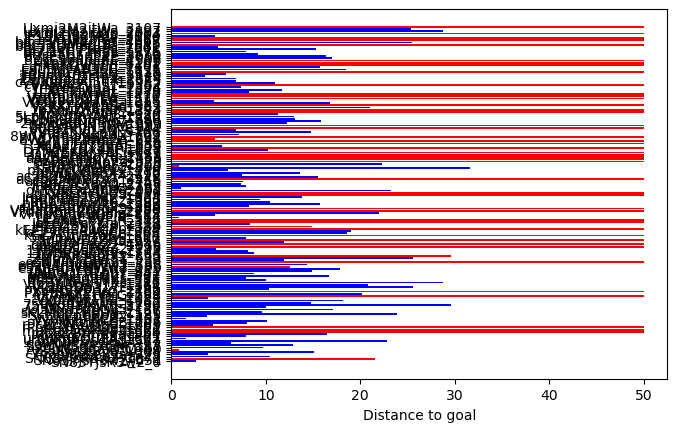

Number of trajectories: 150
Number of successes: 3
                   Distance  Proportional_Distance  Error             Label
gTV8FGcVJC9 2002   1.046175              93.969495      0  gTV8FGcVJC9_2002
ULsKaCPVFJR 564    4.616418              80.983403      0   ULsKaCPVFJR_564
ur6pFq6Qu1A 1597   1.521624              70.992161      0  ur6pFq6Qu1A_1597
D7N2EKCX4Sj 1071  10.189974              68.373958      0  D7N2EKCX4Sj_1071
vyrNrziPKCB 1363   1.514558              47.625631      0  vyrNrziPKCB_1363
17DRP5sb8fy 1794   8.066872              42.348015      0  17DRP5sb8fy_1794
sKLMLpTHeUy 2166  17.142883              40.991548      0  sKLMLpTHeUy_2166
8WUmhLawc2A 1602   7.177475              39.391298      0  8WUmhLawc2A_1602
82sE5b5pLXE 3619   9.162109              37.552785      0  82sE5b5pLXE_3619
rPc6DW4iMge 1603   8.056306              36.904005      0  rPc6DW4iMge_1603
r47D5H71a5s 1576   7.865715              34.697478      0  r47D5H71a5s_1576
SN83YJsR3w2 0      2.648154          

In [45]:
df_results = plot_performance(outputs)
df_results.sort_values(by="Proportional_Distance", ascending=False, inplace=True)
print(f'Number of trajectories: {df_results.shape[0]}')
print(f"Number of successes: {df_results[df_results['Distance']<=1.0].shape[0]}")
print(df_results.head(20))

# Saving output to file
if run_new_trajectories:
    custom_message = "initial-test"
    current_datetime = datetime.now().date()
    output_fname = f"{current_datetime}_{max_scans}-scans_{max_annotations}-annotations_{max_actions}-actions_{custom_message}"

    save_results(df_results, output_dir_path,output_fname + '_results')
    save_results(outputs, output_dir_path, output_fname+'_outputs')

Distance                        10.189974
Proportional_Distance           68.373958
Error                                   0
Label                    D7N2EKCX4Sj_1071
Name: (D7N2EKCX4Sj, 1071), dtype: object
Investigating:
scan_id: D7N2EKCX4Sj
instruction_id: 1071


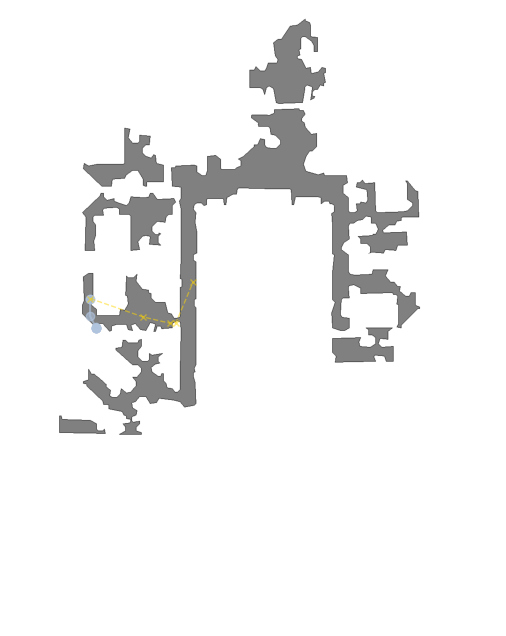

In [46]:
# Investigating a particularly interesting scan and annotation
scan_id = 'D7N2EKCX4Sj'
instruction_id = 1071
try:
    print(df_results.loc[(scan_id, instruction_id)])
except:
    scan_id = df_results.index[0][0]
    instruction_id = df_results.index[0][1]
    print(df_results.loc[(scan_id, instruction_id)])

print(f'Investigating:')
print(f'scan_id: {scan_id}')
print(f'instruction_id: {instruction_id}')

# Displaying the map and trajectory achieved (vs gold path)
topdown_map = outputs[scan_id][instruction_id]['topdown_map']
nav_points = outputs[scan_id][instruction_id]['map_nav_points']
gold_path = outputs[scan_id][instruction_id]['map_gold_path']
distances = outputs[scan_id][instruction_id]['distances']
display_map(topdown_map, key_points=nav_points, gold_path=gold_path)

Instructions:
You are in a bedroom. Facing the open door, with a bathroom on your left, walk through the open
door. You are now on a hallway with a wooden railing and blue carpet. Take a left and take a few
steps down the hallway and stop right by the sculpture of a polar bear on your left between two
paintings and on your right looking down at a dining room, you are now at your final destination.

Starting Point: Inside the bedroom, facing the open door with the bathroom on your left.

Checkpoint 1: Walk straight through the open door into the hallway.

Checkpoint 2: Turn left onto the hallway with a wooden railing and blue carpet.

Checkpoint 3: Walk a few steps down the hallway.

Goal: Stop by the sculpture of a polar bear on your left, between two paintings, with a view of the dining room on your right.


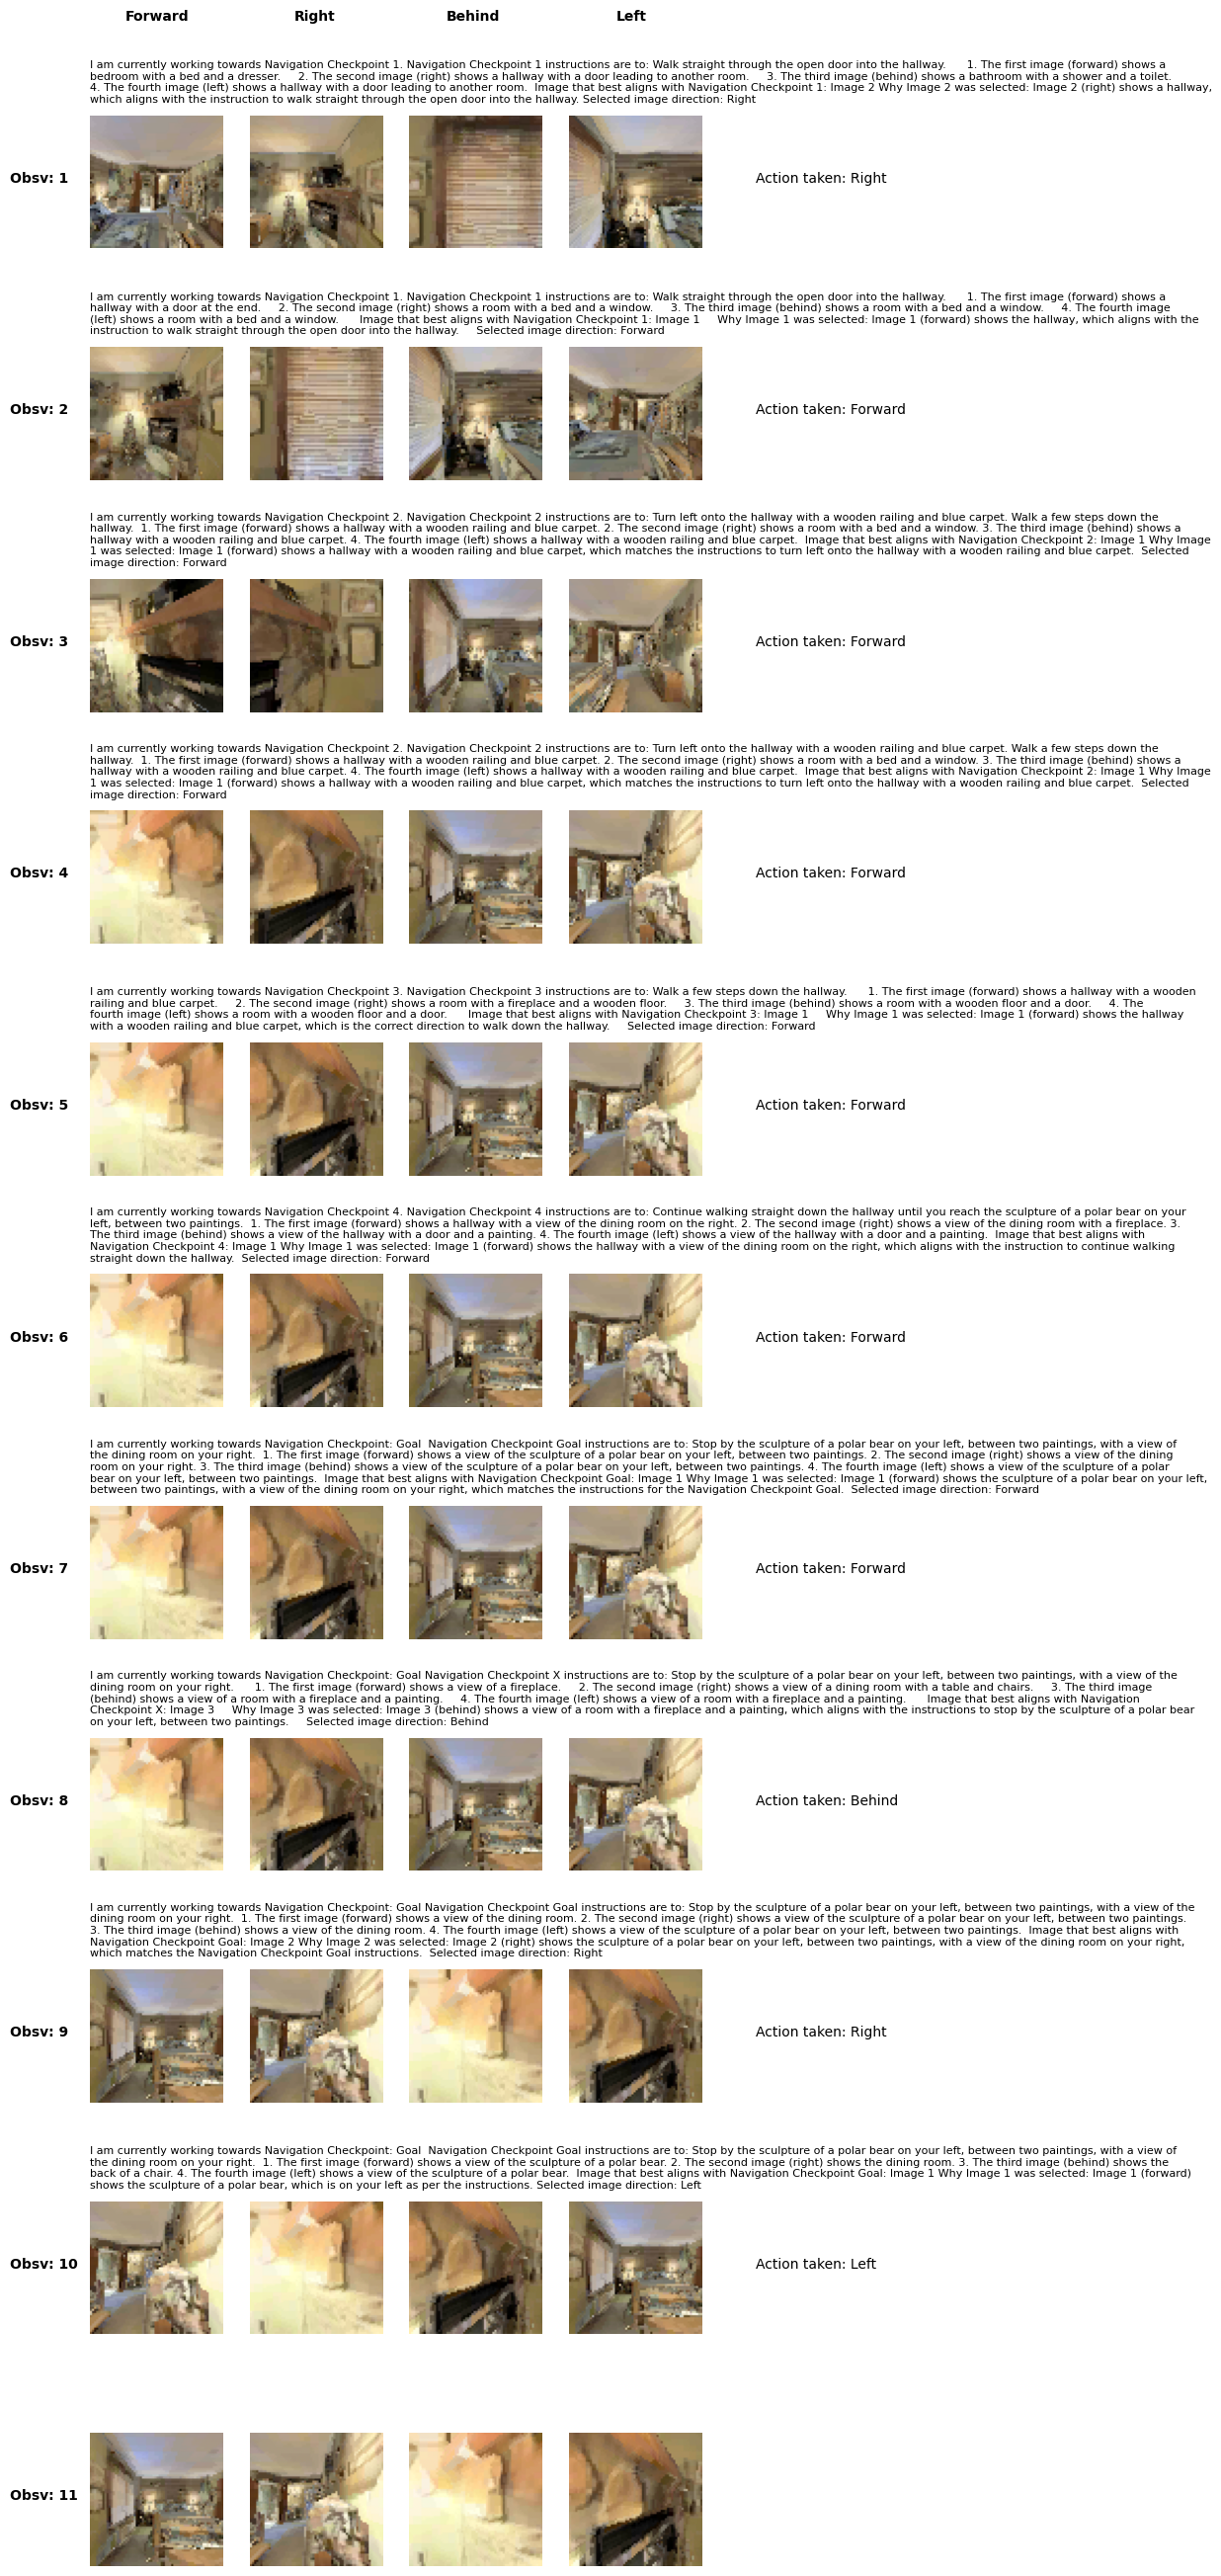

In [ ]:
# Looking more closely into a single trajectory
for annotation in rxr_annotations[scan_id]:
    if annotation['instruction_id'] == instruction_id:
        instruction = annotation['instruction']
print('Instructions:')
print(textwrap.fill(instruction, 100) + '\n')
print(outputs[scan_id][instruction_id]['inferred_nav_instructions'])
draw_trajectory_observations(outputs[scan_id][instruction_id]['observations'],
                             outputs[scan_id][instruction_id]['actions'],
                             outputs[scan_id][instruction_id]['reasoning']
                             )